In [1]:
#1. Setup and Download Dataset

In [1]:
# Install necessary libraries
!pip install librosa audiomentations matplotlib torch torchvision seaborn wget

# Import libraries
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import wget

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 15.7 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=765d2c905ecf97b28b80387af3ff3ab9e9ea84401161e18377c7af2fe9e35433
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [2]:
# Download UrbanSound8K dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
!tar -xvzf UrbanSound8K.tar.gz

# Set paths
data_dir = "UrbanSound8K/audio"
metadata_file = "UrbanSound8K/metadata/UrbanSound8K.csv"


Streaming output truncated to the last 5000 lines.
UrbanSound8K/audio/fold4/17480-2-0-6.wav
UrbanSound8K/audio/fold4/17480-2-0-9.wav
UrbanSound8K/audio/fold4/175904-2-0-11.wav
UrbanSound8K/audio/fold4/175904-2-0-24.wav
UrbanSound8K/audio/fold4/176003-1-0-0.wav
UrbanSound8K/audio/fold4/176638-5-0-0.wav
UrbanSound8K/audio/fold4/177756-2-0-10.wav
UrbanSound8K/audio/fold4/177756-2-0-4.wav
UrbanSound8K/audio/fold4/177756-2-0-5.wav
UrbanSound8K/audio/fold4/177756-2-0-7.wav
UrbanSound8K/audio/fold4/179862-1-0-0.wav
UrbanSound8K/audio/fold4/180977-3-1-1.wav
UrbanSound8K/audio/fold4/180977-3-1-5.wav
UrbanSound8K/audio/fold4/183989-3-1-21.wav
UrbanSound8K/audio/fold4/183989-3-1-23.wav
UrbanSound8K/audio/fold4/185709-0-0-0.wav
UrbanSound8K/audio/fold4/185709-0-0-1.wav
UrbanSound8K/audio/fold4/185709-0-0-6.wav
UrbanSound8K/audio/fold4/185709-0-0-7.wav
UrbanSound8K/audio/fold4/185909-2-0-102.wav
UrbanSound8K/audio/fold4/185909-2-0-13.wav
UrbanSound8K/audio/fold4/185909-2-0-17.wav
UrbanSound8K/audio

In [3]:
#2. Preprocess Dataset

In [4]:
# Load metadata
metadata = pd.read_csv(metadata_file)

# Filter dataset for a few specific classes
selected_classes = ['dog_bark', 'cat_meow', 'chirping_birds']
metadata = metadata[metadata['class'].isin(selected_classes)]

# Map class names to numeric labels
labels_map = {cls: i for i, cls in enumerate(selected_classes)}
metadata['label'] = metadata['class'].map(labels_map)

# Preprocess audio files
def preprocess_audio(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        return spectrogram_db
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Process dataset
# Process dataset
data = []
labels = []

for _, row in metadata.iterrows():
    file_path = os.path.join(data_dir, f"fold{row['fold']}", row['slice_file_name'])
    spectrogram = preprocess_audio(file_path)
    if spectrogram is not None:
        # Pad or truncate spectrograms to a fixed length
        fixed_length = 128  # Choose an appropriate fixed length
        spectrogram = librosa.util.fix_length(spectrogram, size=fixed_length)

        data.append(spectrogram)
        labels.append(row['label'])

data = np.array(data)
labels = np.array(labels)


In [5]:
print(f"Number of processed audio samples: {len(data)}")


Number of processed audio samples: 1000


In [5]:
#3. Visualize Data

Visualizing 5 spectrograms...


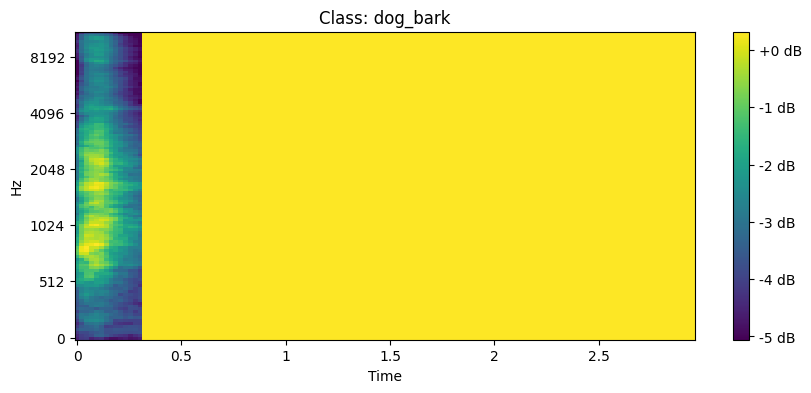

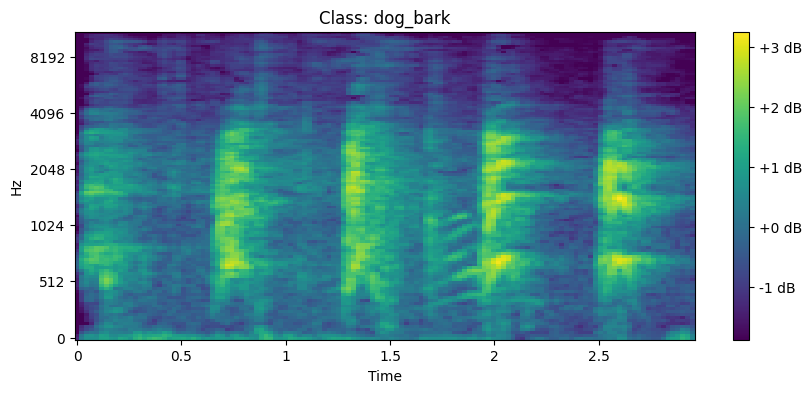

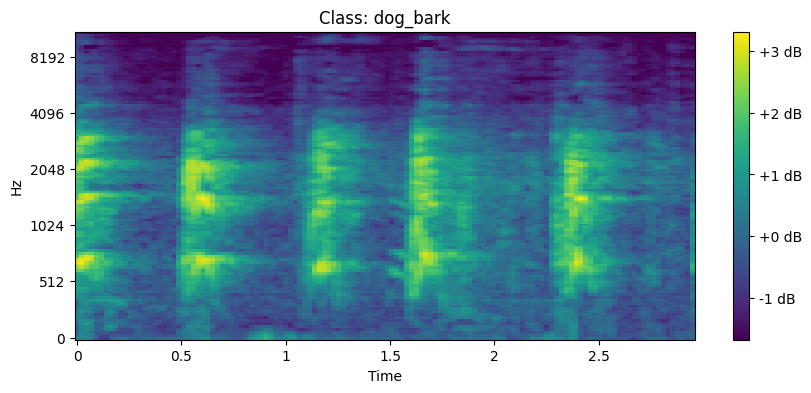

In [17]:
# Visualize a few spectrograms
if len(data) == 0:
    print("Error: No audio files found or processed for the specified labels.")
else:
    print(f"Visualizing {min(5, len(data))} spectrograms...")
    for i in range(min(3, len(data))):  # Show first 3 samples or fewer
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(data[i], sr=22050, x_axis='time', y_axis='mel', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')

        # Map label index to class name
        label_index = labels[i]
        class_name = list(labels_map.keys())[list(labels_map.values()).index(label_index)]
        plt.title(f"Class: {class_name}")
        plt.show()


In [ ]:
#4. Split Dataset and Create PyTorch Dataset

In [7]:
# Normalize spectrograms
data = np.array([(d - np.mean(d)) / np.std(d) for d in data])

# Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# PyTorch dataset
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0), self.labels[idx]  # Add channel dimension

# Create dataloaders
train_dataset = AudioDataset(train_data, train_labels)
test_dataset = AudioDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
#5. Define Model

In [10]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate the correct input size for fc1
        self.fc1 = nn.Linear(32 * 64 * 64//4, 128)  # Corrected input size calculation # The input to the fully connected layer is 32 channels x 64 width x 64 height / 4 (due to two max pooling operations halving both width and height)
        self.fc2 = nn.Linear(128, len(labels_map))  # Number of classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = AudioClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




In [ ]:
#6. Train the Model

In [12]:
# Training loop
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Loss calculation
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels for metrics
        all_preds.extend(preds.numpy())
        all_labels.extend(targets.numpy())

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)

    # Accuracy
    epoch_accuracy = accuracy_score(all_labels, all_preds)

    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    # Print metrics
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Loss: {epoch_loss:.4f}")
    print(f"  Accuracy: {epoch_accuracy * 100:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")



Epoch 1/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 2/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 3/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 4/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 5/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 6/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 7/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 8/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 9/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
Epoch 10/10:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.0000
  Rec

In [ ]:
#7. Evaluate the Model

In [14]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU before converting to NumPy
        all_labels.extend(targets.cpu().numpy()) # Move targets to CPU before converting to NumPy

# Get unique predicted labels
unique_preds = np.unique(all_preds)

# Check if all classes are predicted
if len(unique_preds) != len(labels_map):
    print(f"Warning: Model only predicted classes: {unique_preds}")
    print("Consider adjusting model architecture, training, or data preprocessing.")
    # If necessary, filter target names to match predicted classes
    target_names = [list(labels_map.keys())[i] for i in unique_preds]
else:
    target_names = list(labels_map.keys())

# Classification report
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns

Consider adjusting model architecture, training, or data preprocessing.
              precision    recall  f1-score   support

    dog_bark       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<module 'seaborn' from '/usr/local/lib/python3.10/dist-packages/seaborn/__init__.py'>

In [ ]:
#8. Save and Test the Model

In [15]:
# Save the model
torch.save(model.state_dict(), "audio_classifier.pth")

# Load the model for future use
model.load_state_dict(torch.load("audio_classifier.pth"))


<ipython-input-15-eee8d617f75d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("audio_classifier.pth"))


<All keys matched successfully>